In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from tabulate import tabulate
import itertools

In [2]:
plt.style.use("seaborn-darkgrid")
plt.rcParams["patch.force_edgecolor"] = True

In [3]:
def load_churn_data(filename):
    df = pd.read_csv(filename)
    df.dropna(subset=['avg_rating_by_driver'], inplace=True)
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], yearfirst=True, format='%Y/%m/%d')
    df['signup_date'] = pd.to_datetime(df['signup_date'], yearfirst=True, format='%Y/%m/%d')
    churn_date = pd.datetime(2014, 7, 1) - pd.to_timedelta(30, unit='D')
    two_week_date = pd.datetime(2014, 7, 1) - pd.to_timedelta(14, unit='D')
    df['ride_last_two_weeks'] = df["last_trip_date"] >= two_week_date
    df['churn'] = df["last_trip_date"] < churn_date
    return df

In [4]:
def df_dummies(df, dummyvars):
    for var in dummyvars:
        df = pd.concat([df, pd.get_dummies(df[var])], axis=1)
    return df

In [5]:
def create_Xy(df, y_col, X_drop):
    y = df.pop(y_col)
    X = df.drop(X_drop, axis=1)
    return X, y

In [6]:
def impute_knn(df):
    impute_df = df.dropna()
    X_impute, y_impute = create_Xy(impute_df, 'avg_rating_of_driver', [
                                   'last_trip_date', 'signup_date', 'city', 'phone'])
    k = round(sqrt(len(y_impute)))

    # knn_grid = {'n_neighbors': [5,20,50,k,1000],
                # 'weights': ['uniform', 'distance'],
                # }

    # grid_knn= GridSearchCV(KNeighborsRegressor(), knn_grid)
    # kgrid = grid_knn.fit(X_impute,y_impute)
    # print(kgrid.best_params_)

    best_knn = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    best_knn.fit(X_impute, y_impute)
    X_true = df.drop(['last_trip_date', 'signup_date', 'city',
                      'phone', 'avg_rating_of_driver'], axis=1)
    df['avg_rating_impute'] = best_knn.predict(X_true)
    df['avg_rating_of_driver'].fillna(df['avg_rating_impute'], inplace=True)
    df.drop(['avg_rating_impute'], axis=1, inplace=True)
    return df

In [7]:
# if __name__ == '__main__':

In [8]:
# load data
df = load_churn_data('../data/churn_train.csv')

In [9]:
# create dummies
dummyvars = ['city', 'phone']
df = df_dummies(df, dummyvars)

In [10]:
#impute avg_rating_of_driver
df_imputed = impute_knn(df)

In [11]:
#Create X and y arrays
Xdf, ydf = create_Xy(df_imputed, 'churn', ['last_trip_date', 'signup_date', 'city', 'phone'])
X = Xdf.values
y = ydf.values
Xcols = Xdf.columns

In [12]:
# create train test split on the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [13]:
# standardize data
standardizer = StandardScaler()
standardizer.fit(X_train, y_train)
X_train_std = standardizer.transform(X_train)
X_test_std = standardizer.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
# create scoring list for classification models
#scoring = ['roc_auc', 'accuracy']

In [15]:
# random forest grid search

rf_grid = {'max_depth': [10, None],
           'min_samples_split': [2, 4],
           'min_samples_leaf': [1, 2],
           'n_estimators': [100],
           'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             rf_grid,
                             n_jobs=-1,
                             verbose=True,
                             cv=3)

rf_gridsearch.fit(X_train_std, y_train)

print("best parameters rf: {}".format(rf_gridsearch.best_params_))

rf_best_model = rf_gridsearch.best_estimator_

rf_best_model.fit(X_train_std, y_train)

rf_y_preds_best = rf_best_model.predict(X_test_std)

rf_best_roc_auc = roc_auc_score(y_test, rf_y_preds_best)
rf_best_accuracy = accuracy_score(y_test, rf_y_preds_best)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   23.7s finished


best parameters rf: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 1}


In [16]:
print('best rf model roc_auc: {}'.format(rf_best_roc_auc))
print('best rf model accuracy: {}'.format(rf_best_accuracy))
print(classification_report(y_test, rf_y_preds_best))
print(confusion_matrix(y_test, rf_y_preds_best))

best rf model roc_auc: 0.8629330630181786
best rf model accuracy: 0.8912650602409639
             precision    recall  f1-score   support

      False       0.95      0.75      0.84      3758
       True       0.86      0.98      0.92      6202

avg / total       0.90      0.89      0.89      9960

[[2809  949]
 [ 134 6068]]


In [17]:
# adaboost grid search

ab_grid = {'n_estimators': [50, 100],
           'random_state': [1],
           'learning_rate': [0.05]}

ab_gridsearch = GridSearchCV(AdaBoostClassifier(),
                             ab_grid,
                             n_jobs=-1,
                             verbose=True,
                             cv=3)

ab_gridsearch.fit(X_train_std, y_train)

print("best parameters ab: {}".format(ab_gridsearch.best_params_))

ab_best_model = ab_gridsearch.best_estimator_

ab_best_model.fit(X_train_std, y_train)

ab_y_preds_best = ab_best_model.predict(X_test_std)

ab_best_roc_auc = roc_auc_score(y_test, ab_y_preds_best)
ab_best_accuracy = accuracy_score(y_test, ab_y_preds_best)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.3s finished


best parameters ab: {'learning_rate': 0.05, 'n_estimators': 100, 'random_state': 1}


In [18]:
print('best ab model roc_auc: {}'.format(ab_best_roc_auc))
print('best ab model accuracy: {}'.format(ab_best_accuracy))
print(classification_report(y_test, ab_y_preds_best))
print(confusion_matrix(y_test, ab_y_preds_best))

best ab model roc_auc: 0.8484769200959913
best ab model accuracy: 0.8853413654618474
             precision    recall  f1-score   support

      False       1.00      0.70      0.82      3758
       True       0.85      1.00      0.92      6202

avg / total       0.90      0.89      0.88      9960

[[2624 1134]
 [   8 6194]]


In [19]:
# gradient boosing grid search

gdbr_grid = {'max_depth': [10],
             'min_samples_split': [4],
             'min_samples_leaf': [1],
             'n_estimators': [100],
             'random_state': [1],
             'learning_rate': [0.05]}

gdbr_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                               gdbr_grid,
                               n_jobs=-1,
                               verbose=True,
                               cv=3)

gdbr_gridsearch.fit(X_train_std, y_train)

print("best parameters gdbr: {}".format(gdbr_gridsearch.best_params_))

gdbr_best_model = gdbr_gridsearch.best_estimator_

gdbr_best_model.fit(X_train_std, y_train)

gdbr_y_preds_best = gdbr_best_model.predict(X_test_std)

gdbr_best_roc_auc = roc_auc_score(y_test, gdbr_y_preds_best)
gdbr_best_accuracy = accuracy_score(y_test, gdbr_y_preds_best)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.0s finished


best parameters gdbr: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 1}


In [20]:
print('best gdbr model roc_auc: {}'.format(gdbr_best_roc_auc))
print('best gdbr model accuracy: {}'.format(gdbr_best_accuracy))
print(classification_report(y_test, gdbr_y_preds_best))
print(confusion_matrix(y_test, gdbr_y_preds_best))

best gdbr model roc_auc: 0.8627453092008466
best gdbr model accuracy: 0.8870481927710844
             precision    recall  f1-score   support

      False       0.92      0.76      0.84      3758
       True       0.87      0.96      0.91      6202

avg / total       0.89      0.89      0.88      9960

[[2870  888]
 [ 237 5965]]


In [21]:
# decision tree grid search

dt_grid = {'max_depth': [10, None],
           'min_samples_split': [2, 4],
           'min_samples_leaf': [1, 2],
           'random_state': [1]}

dt_gridsearch = GridSearchCV(DecisionTreeClassifier(),
                             dt_grid,
                             n_jobs=-1,
                             verbose=True,
                             cv=3)

dt_gridsearch.fit(X_train_std, y_train)

print("best parameters dt: {}".format(dt_gridsearch.best_params_))

dt_best_model = dt_gridsearch.best_estimator_

dt_best_model.fit(X_train_std, y_train)

dt_y_preds_best = dt_best_model.predict(X_test_std)

dt_best_roc_auc = roc_auc_score(y_test, dt_y_preds_best)
dt_best_accuracy = accuracy_score(y_test, dt_y_preds_best)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.0s finished


best parameters dt: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 1}


In [22]:
print('best dt model roc_auc: {}'.format(dt_best_roc_auc))
print('best dt model accuracy: {}'.format(dt_best_accuracy))
print(classification_report(y_test, dt_y_preds_best))
print(confusion_matrix(y_test, dt_y_preds_best))

best dt model roc_auc: 0.8585446607808533
best dt model accuracy: 0.8827309236947791
             precision    recall  f1-score   support

      False       0.91      0.76      0.83      3758
       True       0.87      0.96      0.91      6202

avg / total       0.89      0.88      0.88      9960

[[2856  902]
 [ 266 5936]]


In [23]:
# logistic regression grid search

log_grid = {'random_state': [1]}

log_gridsearch = GridSearchCV(LogisticRegression(),
                              log_grid,
                              n_jobs=-1,
                              verbose=True,
                              cv=3)

log_gridsearch.fit(X_train_std, y_train)

print("best parameters dt: {}".format(log_gridsearch.best_params_))

log_best_model = log_gridsearch.best_estimator_

log_best_model.fit(X_train_std, y_train)

log_y_preds_best = log_best_model.predict(X_test_std)

log_best_roc_auc = roc_auc_score(y_test, log_y_preds_best)
log_best_accuracy = accuracy_score(y_test, log_y_preds_best)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


best parameters dt: {'random_state': 1}


In [24]:
print('best log reg model roc_auc: {}'.format(log_best_roc_auc))
print('best log reg model accuracy: {}'.format(log_best_accuracy))
print(classification_report(y_test, log_y_preds_best))
print(confusion_matrix(y_test, log_y_preds_best))

best log reg model roc_auc: 0.8516796758552196
best log reg model accuracy: 0.8842369477911647
             precision    recall  f1-score   support

      False       0.97      0.72      0.82      3758
       True       0.85      0.98      0.91      6202

avg / total       0.90      0.88      0.88      9960

[[2702 1056]
 [  97 6105]]


In [25]:
### RUN BEST MODEL ON TEST DATA ###

# load data
df_final = load_churn_data('../data/churn_test.csv')

In [26]:
# create dummies
dummyvars = ['city', 'phone']
df_final = df_dummies(df_final, dummyvars)

In [27]:
#impute avg_rating_of_driver
df_imputed_final = impute_knn(df_final)

In [28]:
#Create X and y arrays
Xdf_final, ydf_final = create_Xy(df_imputed_final, 'churn', [
                                 'last_trip_date', 'signup_date', 'city', 'phone'])
X_final = Xdf.values
y_final = ydf.values
Xcols = Xdf_final.columns

In [29]:
# standardize data
standardizer_final = StandardScaler()
standardizer_final.fit(X_final, y_final)
X_final_std = standardizer.transform(X_final)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [30]:
# random forest final run
rf_y_preds_best_final = rf_best_model.predict(X_final_std)
rf_y_probs_final = rf_best_model.predict_proba(X_final_std)

rf_best_roc_auc_final = roc_auc_score(y_final, rf_y_preds_best_final)
rf_best_accuracy_final = accuracy_score(y_final, rf_y_preds_best_final)

In [31]:
print('final rf model roc_auc: {}'.format(rf_best_roc_auc_final))
print('final rf model accuracy: {}'.format(rf_best_accuracy_final))
print(classification_report(y_final, rf_y_preds_best_final))
print(confusion_matrix(y_final, rf_y_preds_best_final))

final rf model roc_auc: 0.8713623292267225
final rf model accuracy: 0.8992419298157538
             precision    recall  f1-score   support

      False       0.97      0.76      0.85     15000
       True       0.87      0.98      0.92     24838

avg / total       0.91      0.90      0.90     39838

[[11377  3623]
 [  391 24447]]


In [32]:
# ada boost final run

ab_y_preds_best_final = ab_best_model.predict(X_final_std)
ab_y_probs_final = ab_best_model.predict_proba(X_final_std)

ab_best_roc_auc_final = roc_auc_score(y_final, ab_y_preds_best_final)
ab_best_accuracy_final = accuracy_score(y_final, ab_y_preds_best_final)

In [33]:
print('final ab model roc_auc: {}'.format(ab_best_roc_auc_final))
print('final ab model accuracy: {}'.format(ab_best_accuracy_final))
print(classification_report(y_final, ab_y_preds_best_final))
print(confusion_matrix(y_final, ab_y_preds_best_final))

final ab model roc_auc: 0.8446759561961511
final ab model accuracy: 0.8827250363974095
             precision    recall  f1-score   support

      False       1.00      0.69      0.82     15000
       True       0.84      1.00      0.91     24838

avg / total       0.90      0.88      0.88     39838

[[10359  4641]
 [   31 24807]]


In [34]:
# gradient boosting final run

gdbr_y_preds_best_final = gdbr_best_model.predict(X_final_std)
gdbr_y_probs_final = gdbr_best_model.predict_proba(X_final_std)

gdbr_best_roc_auc_final = roc_auc_score(y_final, gdbr_y_preds_best_final)
gdbr_best_accuracy_final = accuracy_score(y_final, gdbr_y_preds_best_final)

In [35]:
print('final gdbr model roc_auc: {}'.format(gdbr_best_roc_auc_final))
print('final gdbr model accuracy: {}'.format(gdbr_best_accuracy_final))
print(classification_report(y_final, gdbr_y_preds_best_final))
print(confusion_matrix(y_final, gdbr_y_preds_best_final))

final gdbr model roc_auc: 0.9072184019110502
final gdbr model accuracy: 0.9264521311310808
             precision    recall  f1-score   support

      False       0.97      0.83      0.89     15000
       True       0.91      0.99      0.94     24838

avg / total       0.93      0.93      0.93     39838

[[12440  2560]
 [  370 24468]]


In [36]:
# decision tree final run

dt_y_preds_best_final = dt_best_model.predict(X_final_std)
dt_y_probs_final = dt_best_model.predict_proba(X_final_std)

dt_best_roc_auc_final = roc_auc_score(y_final, dt_y_preds_best_final)
dt_best_accuracy_final = accuracy_score(y_final, dt_y_preds_best_final)

In [37]:
print('final dt model roc_auc: {}'.format(dt_best_roc_auc_final))
print('final dt model accuracy: {}'.format(dt_best_accuracy_final))
print(classification_report(y_final, dt_y_preds_best_final))
print(confusion_matrix(y_final, dt_y_preds_best_final))

final dt model roc_auc: 0.8743209920283437
final dt model accuracy: 0.8978111350971434
             precision    recall  f1-score   support

      False       0.94      0.78      0.85     15000
       True       0.88      0.97      0.92     24838

avg / total       0.90      0.90      0.90     39838

[[11688  3312]
 [  759 24079]]


In [38]:
# logistic regression final run

log_y_preds_best_final = log_best_model.predict(X_final_std)
log_y_probs_final = log_best_model.predict_proba(X_final_std)

log_best_roc_auc_final = roc_auc_score(y_final, log_y_preds_best_final)
log_best_accuracy_final = accuracy_score(y_final, log_y_preds_best_final)

In [39]:
print('final log reg model roc_auc: {}'.format(log_best_roc_auc_final))
print('final log reg model accuracy: {}'.format(log_best_accuracy_final))
print(classification_report(y_final, log_y_preds_best_final))
print(confusion_matrix(y_final, log_y_preds_best_final))

final log reg model roc_auc: 0.8502201116568698
final log reg model accuracy: 0.8831517646468197
             precision    recall  f1-score   support

      False       0.96      0.72      0.82     15000
       True       0.85      0.98      0.91     24838

avg / total       0.89      0.88      0.88     39838

[[10753  4247]
 [  408 24430]]


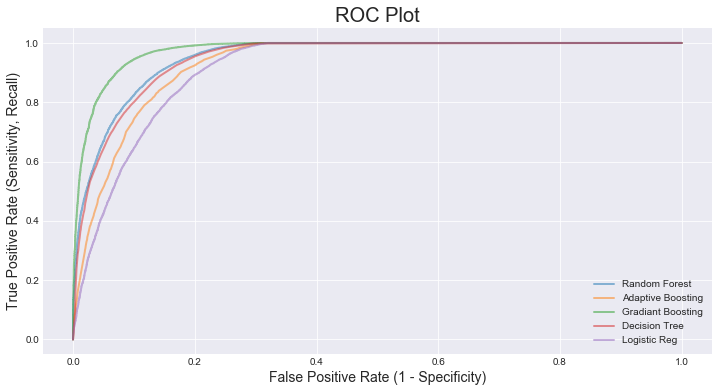

In [40]:
### Plots for presentation ###

# roc curve

rf_fpr, rf_tpr, t1 = roc_curve(y_final, rf_y_probs_final[:, 1])
ab_fpr, ab_tpr, t2 = roc_curve(y_final, ab_y_probs_final[:, 1])
gdbr_fpr, gdbr_tpr, t3 = roc_curve(y_final, gdbr_y_probs_final[:, 1])
dt_fpr, dt_tpr, t4 = roc_curve(y_final, dt_y_probs_final[:, 1])
log_fpr, log_tpr, t5 = roc_curve(y_final, log_y_probs_final[:, 1])

plt.style.use("seaborn-darkgrid")
plt.rcParams["patch.force_edgecolor"] = True
plt.figure(figsize=(12, 6))
plt.plot(rf_fpr, rf_tpr, label='Random Forest', alpha=0.5, linewidth=2)
plt.plot(ab_fpr, ab_tpr, label='Adaptive Boosting', alpha=0.5, linewidth=2)
plt.plot(gdbr_fpr, gdbr_tpr, label='Gradiant Boosting', alpha=0.5, linewidth=2)
plt.plot(dt_fpr, dt_tpr, label='Decision Tree', alpha=0.5, linewidth=2)
plt.plot(log_fpr, log_tpr, label='Logistic Reg', alpha=0.5, linewidth=2)
plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=14)
plt.ylabel("True Positive Rate (Sensitivity, Recall)", fontsize=14)
plt.title("ROC Plot", fontsize=20)
plt.legend()
# plt.savefig("ROC_Curve.png")
plt.show();

In [41]:
# Sample Decision Tree
dt_df = pd.DataFrame(X_train_std, columns=Xcols)

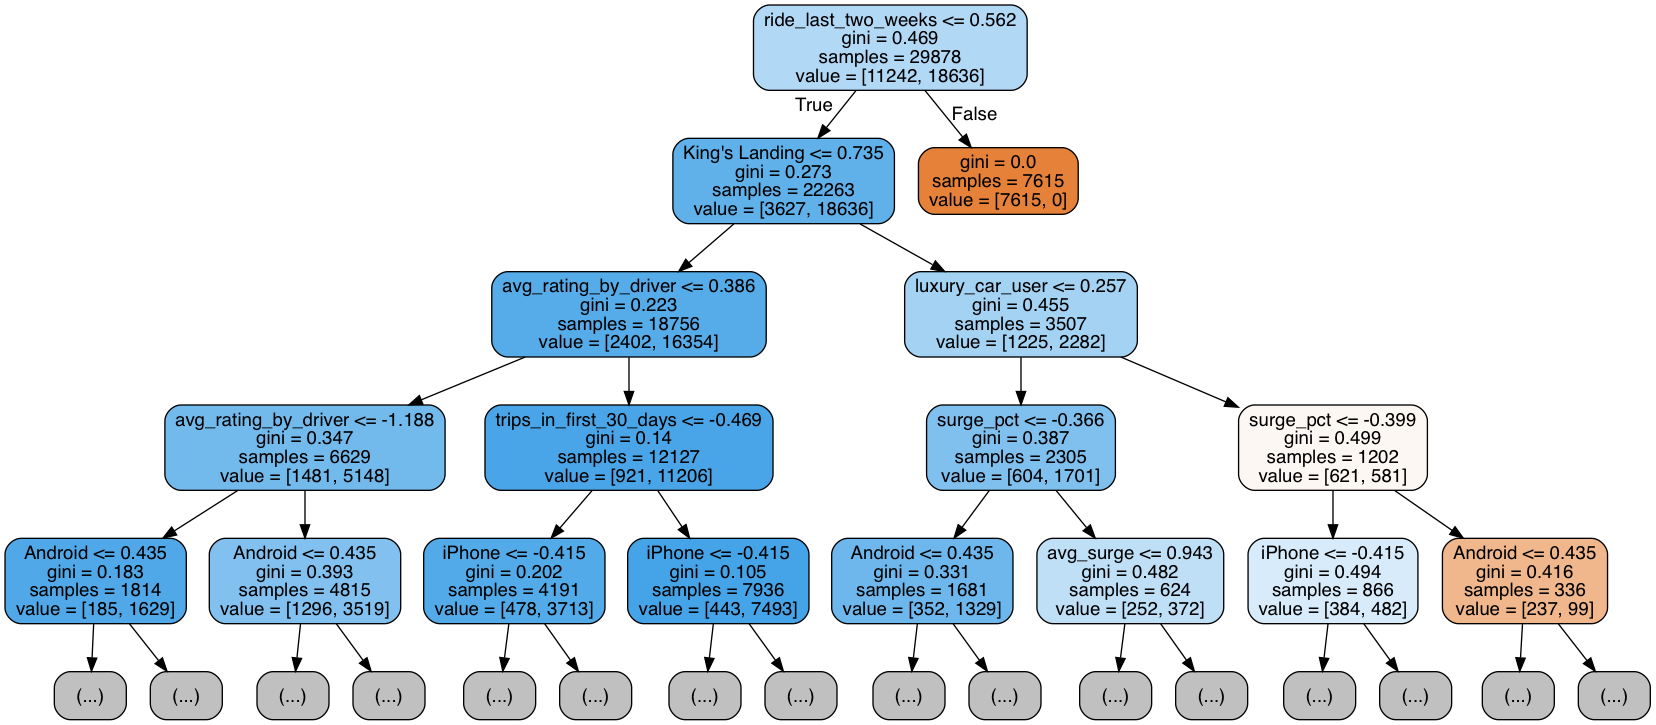

In [43]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(dt_df.columns)
dot_data = StringIO()  
export_graphviz(dt_best_model, out_file=dot_data, max_depth=4, feature_names=features, filled=True, rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())
# Image(graph[0].write_png('decision_tree.png'))

In [44]:
# feature importance graphs
def feature_importance_df(model, columns):
    importances = model.feature_importances_
    try:
        std = np.std([feat.feature_importances_ for feat in model.estimators_],
                     axis=0)
    except:
        std = 0
    feature_df = pd.DataFrame(columns=['feature', 'importance', 'std'])
    feature_df['feature'] = Xcols
    feature_df['importance'] = importances
    feature_df['std'] = std
    sort_feat_imp = feature_df.sort_values('importance', ascending=False).reset_index(drop=True)
    sort_feat_imp.index = np.arange(1,len(Xcols)+1)
    return sort_feat_imp

In [45]:
def coef_rank(model, columns):
    coef = [item for item in model.coef_.reshape(len(columns,))]
    std=0
    feature_df = pd.DataFrame(columns=['feature', 'coef', 'std'])
    feature_df['feature'] = Xcols
    feature_df['coef'] = coef
    feature_df['std'] = std
    feature_df['sort'] = feature_df['coef'].abs()
    sort_feat_imp = feature_df.sort_values('sort', ascending=False).reset_index(drop=True)
    return sort_feat_imp.drop('sort', axis=1)

In [46]:
def feat_importance_graph(feat_df, model_name, save_fig=False):
    plt.figure(figsize=(14,7))
    plt.title(f"{model_name} Feature Importances", fontsize=20)
    plt.bar(range(X.shape[1]), feat_df[feat_df.columns[1]], yerr=feat_df['std'], align="center")
    plt.xticks(range(X.shape[1]), feat_df['feature'], rotation=45, fontsize=12)
    plt.xlim([-1, X.shape[1]])
    if save_fig:
        filename = model_name.replace(' ', '_').lower() + '_feat_importance.png'
        plt.savefig(filename)
    plt.show();

In [47]:
rf_df = feature_importance_df(rf_best_model, Xcols)
ab_df = feature_importance_df(ab_best_model, Xcols)
gdbr_df = feature_importance_df(gdbr_best_model, Xcols)
dt_df = feature_importance_df(dt_best_model, Xcols)
log_df = coef_rank(log_best_model, Xcols)

In [48]:
model_dict = {'Random Forest': rf_df, 'Adaptive Boosting': ab_df,
              'Gradiant Boosting': gdbr_df, 'Decision Tree': dt_df, 'Logistic Regression': log_df}

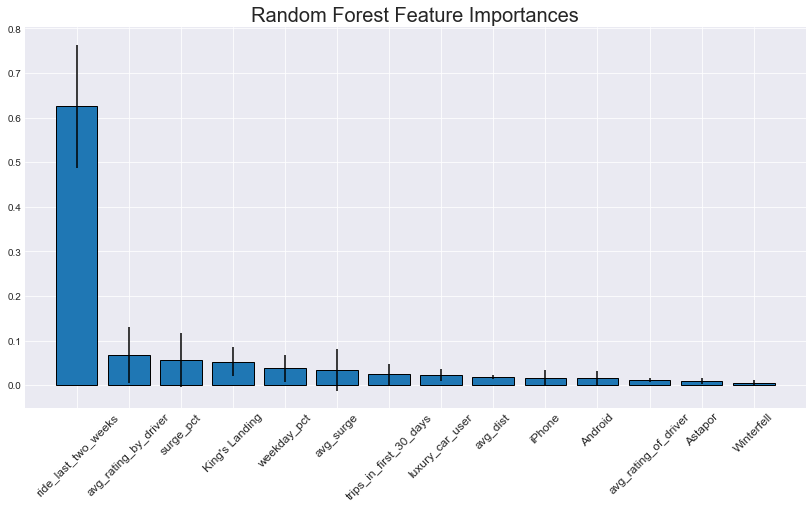

Random Forest:

|    | feature                |   importance |
|---:|:-----------------------|-------------:|
|  1 | ride_last_two_weeks    |      0.62499 |
|  2 | avg_rating_by_driver   |      0.06696 |
|  3 | surge_pct              |      0.05664 |
|  4 | King's Landing         |      0.05292 |
|  5 | weekday_pct            |      0.03764 |
|  6 | avg_surge              |      0.03496 |
|  7 | trips_in_first_30_days |      0.02428 |
|  8 | luxury_car_user        |      0.02341 |
|  9 | avg_dist               |      0.01883 |
| 10 | iPhone                 |      0.01704 |
| 11 | Android                |      0.01578 |
| 12 | avg_rating_of_driver   |      0.01201 |
| 13 | Astapor                |      0.00892 |
| 14 | Winterfell             |      0.00564 |




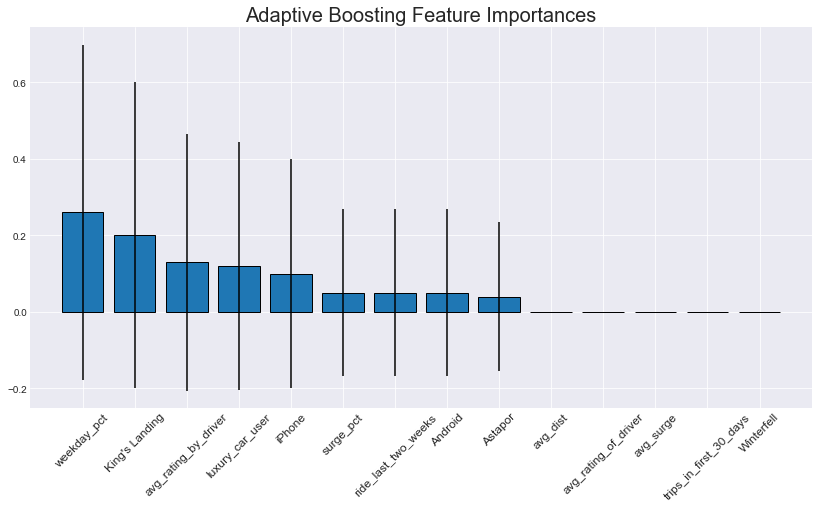

Adaptive Boosting:

|    | feature                |   importance |
|---:|:-----------------------|-------------:|
|  1 | weekday_pct            |         0.26 |
|  2 | King's Landing         |         0.2  |
|  3 | avg_rating_by_driver   |         0.13 |
|  4 | luxury_car_user        |         0.12 |
|  5 | iPhone                 |         0.1  |
|  6 | surge_pct              |         0.05 |
|  7 | ride_last_two_weeks    |         0.05 |
|  8 | Android                |         0.05 |
|  9 | Astapor                |         0.04 |
| 10 | avg_dist               |         0    |
| 11 | avg_rating_of_driver   |         0    |
| 12 | avg_surge              |         0    |
| 13 | trips_in_first_30_days |         0    |
| 14 | Winterfell             |         0    |




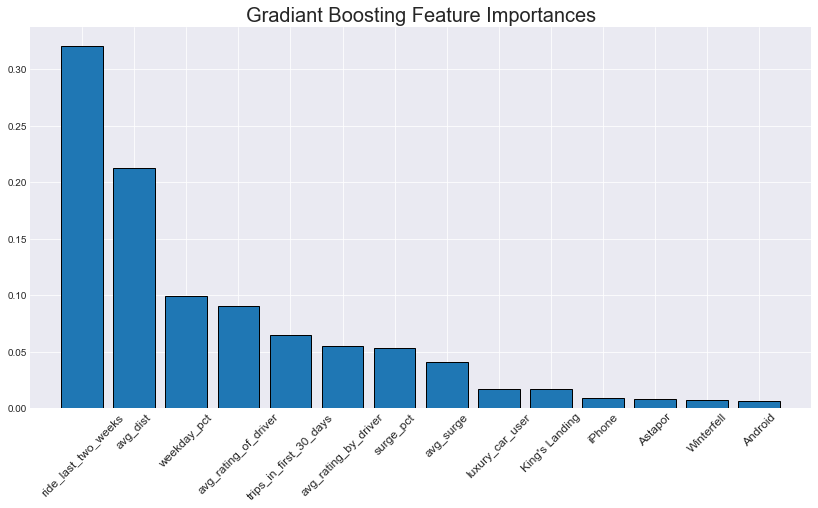

Gradiant Boosting:

|    | feature                |   importance |
|---:|:-----------------------|-------------:|
|  1 | ride_last_two_weeks    |      0.32084 |
|  2 | avg_dist               |      0.2125  |
|  3 | weekday_pct            |      0.09925 |
|  4 | avg_rating_of_driver   |      0.09056 |
|  5 | trips_in_first_30_days |      0.0649  |
|  6 | avg_rating_by_driver   |      0.05444 |
|  7 | surge_pct              |      0.0532  |
|  8 | avg_surge              |      0.0406  |
|  9 | luxury_car_user        |      0.01701 |
| 10 | King's Landing         |      0.01691 |
| 11 | iPhone                 |      0.0089  |
| 12 | Astapor                |      0.00771 |
| 13 | Winterfell             |      0.00679 |
| 14 | Android                |      0.00639 |




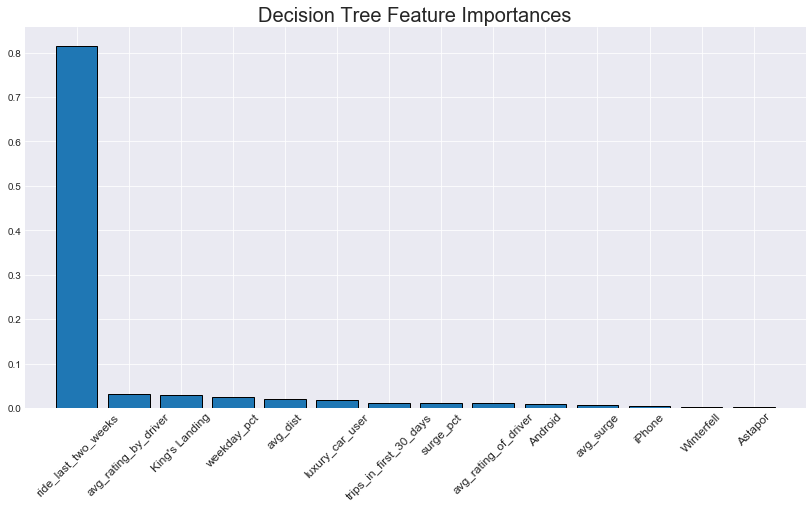

Decision Tree:

|    | feature                |   importance |
|---:|:-----------------------|-------------:|
|  1 | ride_last_two_weeks    |      0.81593 |
|  2 | avg_rating_by_driver   |      0.03231 |
|  3 | King's Landing         |      0.02968 |
|  4 | weekday_pct            |      0.02422 |
|  5 | avg_dist               |      0.01919 |
|  6 | luxury_car_user        |      0.01792 |
|  7 | trips_in_first_30_days |      0.01204 |
|  8 | surge_pct              |      0.01201 |
|  9 | avg_rating_of_driver   |      0.01071 |
| 10 | Android                |      0.0101  |
| 11 | avg_surge              |      0.00635 |
| 12 | iPhone                 |      0.0056  |
| 13 | Winterfell             |      0.00262 |
| 14 | Astapor                |      0.00132 |




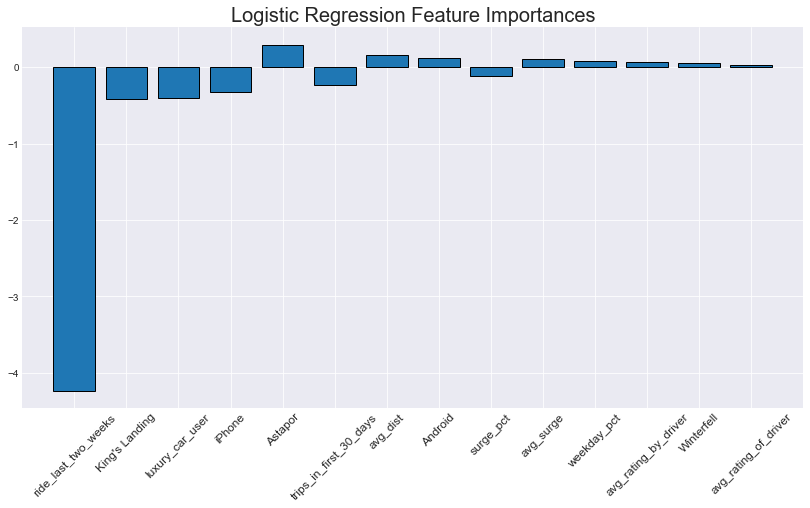

Logistic Regression:

|    | feature                |     coef |
|---:|:-----------------------|---------:|
|  0 | ride_last_two_weeks    | -4.23607 |
|  1 | King's Landing         | -0.41918 |
|  2 | luxury_car_user        | -0.40778 |
|  3 | iPhone                 | -0.3195  |
|  4 | Astapor                |  0.29361 |
|  5 | trips_in_first_30_days | -0.23531 |
|  6 | avg_dist               |  0.15473 |
|  7 | Android                |  0.12595 |
|  8 | surge_pct              | -0.11914 |
|  9 | avg_surge              |  0.11285 |
| 10 | weekday_pct            |  0.07656 |
| 11 | avg_rating_by_driver   |  0.06791 |
| 12 | Winterfell             |  0.06107 |
| 13 | avg_rating_of_driver   |  0.03122 |




In [49]:
for k, v in model_dict.items():
    feat_importance_graph(v, k, save_fig=False)
    print(f'{k}:\n')
    print(tabulate(v.drop('std', axis=1).round(5), headers='keys', tablefmt='pipe'))
    print('\n')

In [50]:
# confusion matrix 

def plot_confusion_matrix(y_true, y_pred, classes, model_name, include_percent=True, save_fig=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    # first plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid(b=None)
    plt.title('Confusion Matrix', fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # second plot
    if include_percent:
        norm_cm = cm.astype('float') / len(y_true)
        plt.subplot(1, 2, 2)
        plt.imshow(norm_cm, interpolation='nearest', cmap=cmap)
        plt.grid(b=None)
        plt.title('Confusion Matrix %', fontsize=20)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        fmt = '.1%'
        thresh = norm_cm.max() / 2.
        for i, j in itertools.product(range(norm_cm.shape[0]), range(norm_cm.shape[1])):
            plt.text(j, i, format(norm_cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if norm_cm[i, j] > thresh else "black")
        plt.ylabel('True label', fontsize=12)
        plt.xlabel('Predicted label', fontsize=12)

    plt.tight_layout()

    if save_fig:
        filename = model_name.replace(
            ' ', '_').lower() + '_confusion_matrix.png'
        plt.savefig(filename)

    plt.show()

In [51]:
classes = ['False', 'True']
cm_dict = {'Random Forest': [y_final, rf_y_preds_best_final], 'Adaptive Boosting': [y_final, ab_y_preds_best_final], 'Gradiant Boosting': [
    y_final, gdbr_y_preds_best_final], 'Decision Tree': [y_final, dt_y_preds_best_final], 'Logistic Regression': [y_final, log_y_preds_best_final]}

Random Forest:


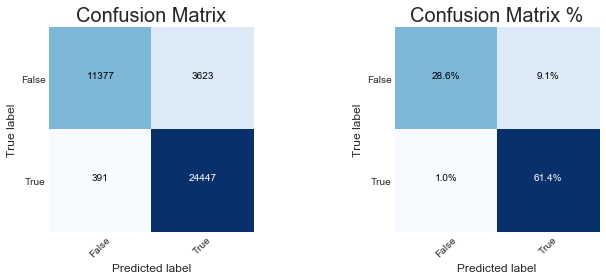



Adaptive Boosting:


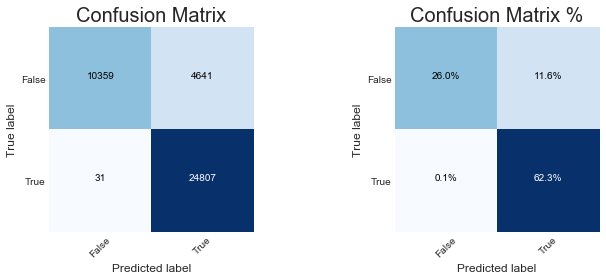



Gradiant Boosting:


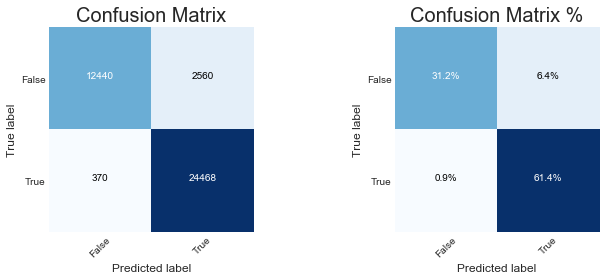



Decision Tree:


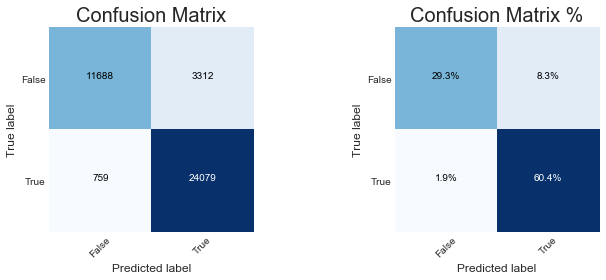



Logistic Regression:


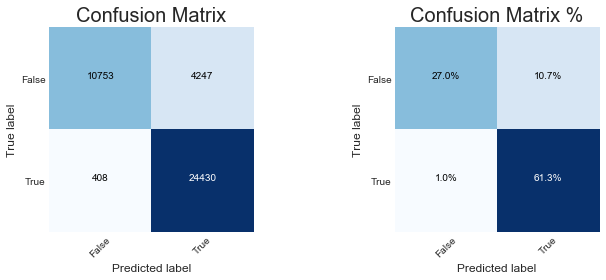

In [52]:
for k, v in cm_dict.items():
    print(f'{k}:')
    plot_confusion_matrix(v[0], v[1], classes, k, save_fig=False)
    print('\n')

In [53]:
# import scipy.stats as scs
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn import metrics
# from sklearn import preprocessing
# from sklearn import tree
# from sklearn import ensemble

# from IPython.display import Image
# import pydotplus  # NOTE: May Require conda install graphviz

In [54]:
# # timeseries cross-validation
# def time_series_cross_validation(target, features, classifier, model_name, n_splits=3):
#     y = target
#     scaler = preprocessing.StandardScaler().fit(features)
#     X = scaler.transform(features)
    
#     # time-series cross-validation
#     tscv = TimeSeriesSplit(n_splits=n_splits)
    
#     # Three subplots
#     f, (ax1, ax2, ax3) = plt.subplots(3, sharex=False, sharey=False, figsize=(16,8))
#     f.subplots_adjust(hspace=0.2)
#     axes = [ax1, ax2, ax3]
#     evaluation_metric = []
#     split = 0
#     for train_index, test_index in tscv.split(X):
#         X_train, X_test = X[train_index], X[test_index]
#         Y_train, Y_test = y[train_index], y[test_index]
#         classifier.fit(X_train, Y_train)
#         y_hat=classifier.predict(X_test)
#         explained_variance = metrics.explained_variance_score(y_true=Y_test, y_pred=y_hat)        
#         evaluation_metric.append(explained_variance)
#         axes[split].plot(pd.DataFrame({'y_hat': y_hat, 'y_true': Y_test}))
#         split += 1
#     axes[0].set_title('{}\n Mean Cross-Validated Explained Variance Score: {:.2f}'.format(
#                     model_name, np.mean(evaluation_metric))
#                      )

In [55]:
# n_features = len(features)

# time_series_cross_validation(
#     target=y,
#     features=X,
#     classifier=ensemble.RandomForestRegressor(criterion='mse',  # feature-splitting criterion
#                                               n_estimators=500, # number of trees
#                                               max_depth=5,      # max tree depth
#                                               max_features=n_features
#                                              ),
#     model_name='Bagging'
# )

In [56]:
# time_series_cross_validation(
#     target=y,
#     features=X,
#     classifier=tree.DecisionTreeRegressor(max_depth=1),
#     model_name='Decision Tree'
# )